In [89]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, KFold, cross_validate
from sklearn.metrics import accuracy_score, f1_score


# Data description and preprocessing

In [90]:
data = pd.read_csv('../dataset/mammographic_masses.data', header=None, na_values='?')
data.columns = ['BI-RADS', 'Age', 'Shape', 'Margin', 'Density', 'Severity']

print("Data shape: " , data.shape)
data.head()

Data shape:  (961, 6)


,BI-RADS,Age,Shape,Margin,Density,Severity
0,5.0,67.0,3.0,5.0,3.0,1
1,4.0,43.0,1.0,1.0,NaN,1
2,5.0,58.0,4.0,5.0,3.0,1
3,4.0,28.0,1.0,1.0,3.0,0
4,5.0,74.0,1.0,5.0,NaN,1


In [91]:
data.describe()

,BI-RADS,Age,Shape,Margin,Density,Severity
count,959.000000,956.000000,930.000000,913.000000,885.000000,961.000000
mean,4.348279,55.487448,2.721505,2.796276,2.910734,0.463059
std,1.783031,14.480131,1.242792,1.566546,0.380444,0.498893
min,0.000000,18.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,45.000000,2.000000,1.000000,3.000000,0.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000,1.000000
max,55.000000,96.000000,4.000000,5.000000,4.000000,1.000000


Fix outliers and missing values

In [92]:
# Check for missing values
for i in data.columns[data.isnull().any(axis=0)]:     #---Applying Only on variables with NaN values
    data[i].fillna(round(data[i].mean()),inplace=True)
data

#---Checking for Outliers
data.drop(data[data['BI-RADS'] >= 6 ].index, inplace=True)
data.drop(data[data['BI-RADS'] <= 0 ].index, inplace=True)

data.describe()

,BI-RADS,Age,Shape,Margin,Density,Severity
count,944.000000,944.000000,944.000000,944.000000,944.000000,944.000000
mean,4.297669,55.399364,2.719280,2.795551,2.916314,0.458686
std,0.612139,14.449328,1.225658,1.531411,0.366099,0.498554
min,2.000000,18.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,45.000000,2.000000,1.000000,3.000000,0.000000
50%,4.000000,56.000000,3.000000,3.000000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000,1.000000
max,5.000000,96.000000,4.000000,5.000000,4.000000,1.000000


Check if data is balanced

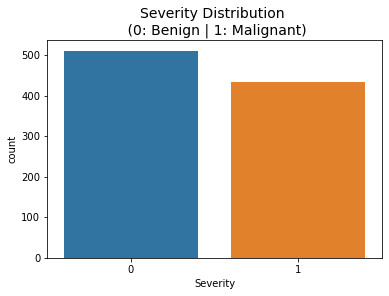

Benign:  54.13 % of the dataset
Malignant:  45.87 % of the dataset


In [93]:
sns.countplot(x='Severity', data=data)
plt.title('Severity Distribution \n (0: Benign | 1: Malignant)', fontsize=14)
plt.show()

print('Benign: ', round(data['Severity'].value_counts()[0]/len(data) * 100,2), '% of the dataset')
print('Malignant: ', round(data['Severity'].value_counts()[1]/len(data) * 100,2), '% of the dataset')


# Data visualization

<Figure size 1440x1440 with 0 Axes>

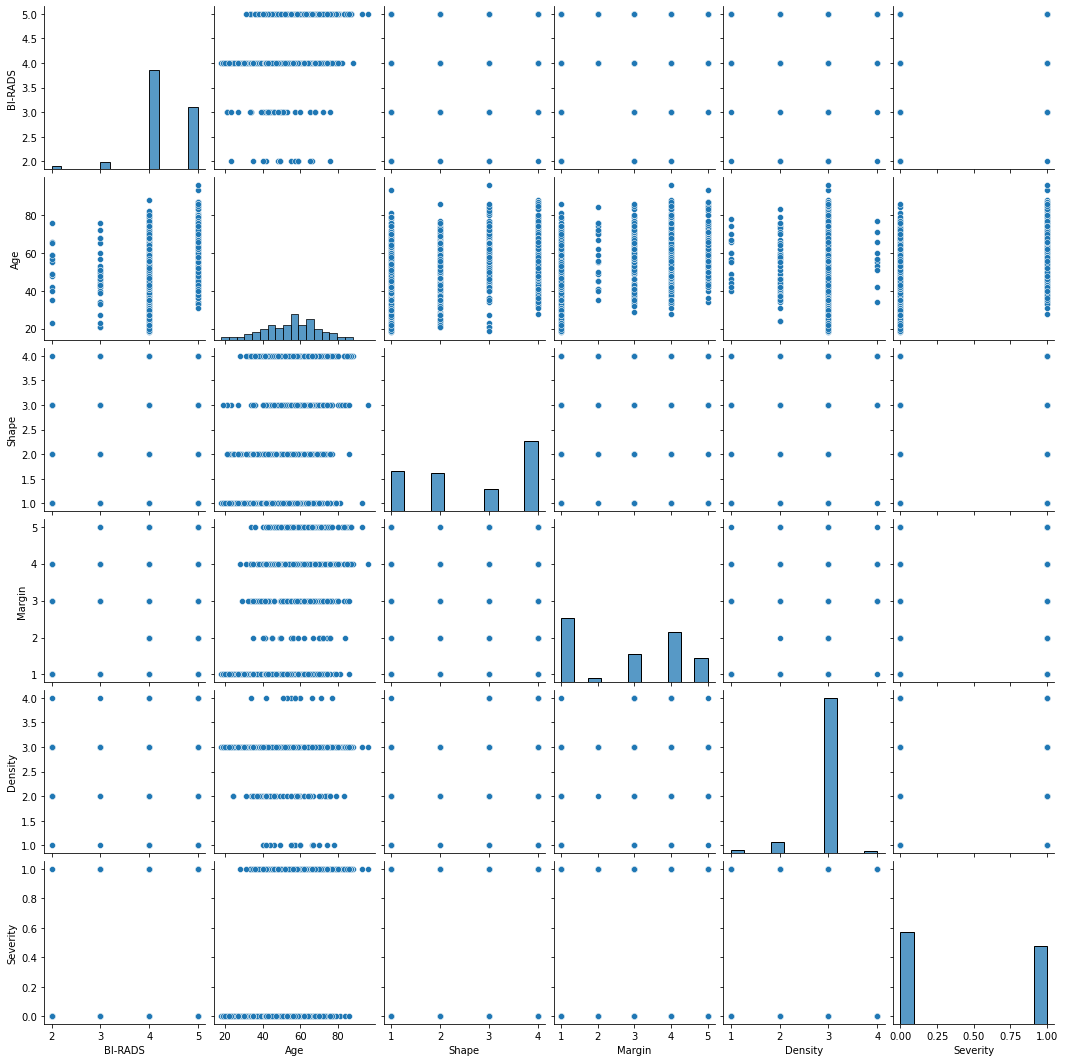

In [94]:
plt.figure(figsize=(20,20))
sns.pairplot(data)
plt.show()

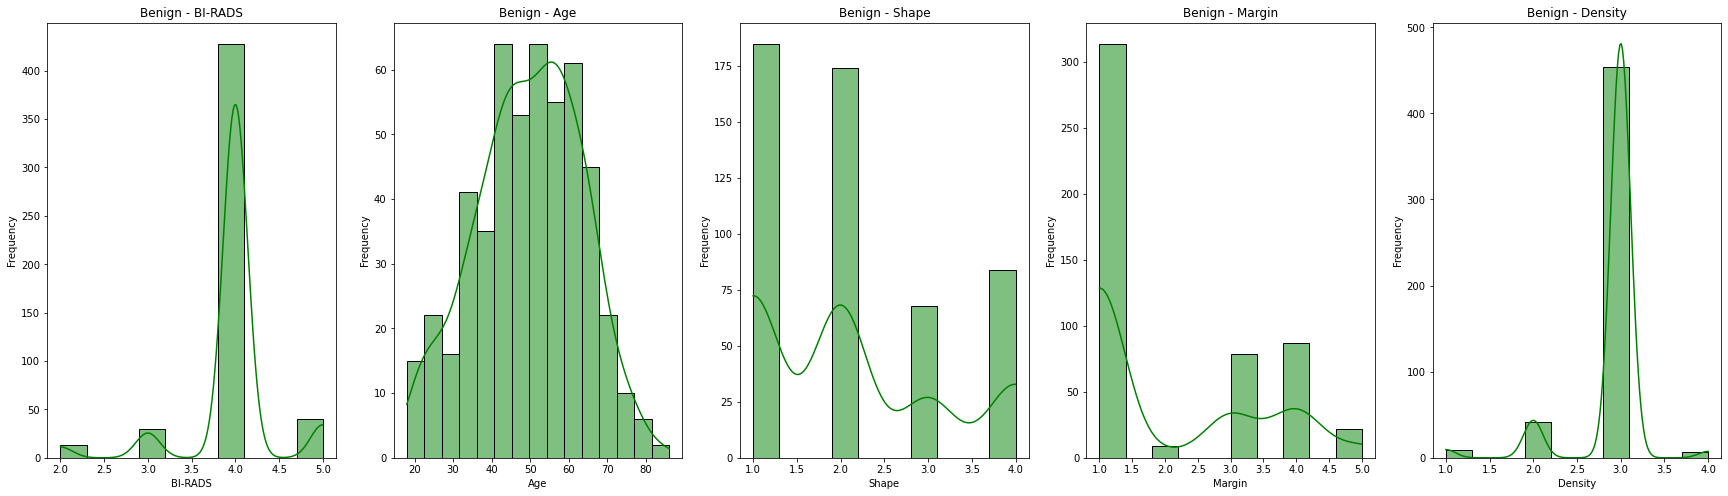

In [95]:
f, axes = plt.subplots(ncols=5, figsize=(30, 8))

for i, col in enumerate(data.columns[0:5]):
    data_benign = data[col][data.Severity == 0].values
    sns.histplot(data_benign, ax=axes[i], kde=True, color='green')
    axes[i].set_title('Benign - ' + col)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.show()

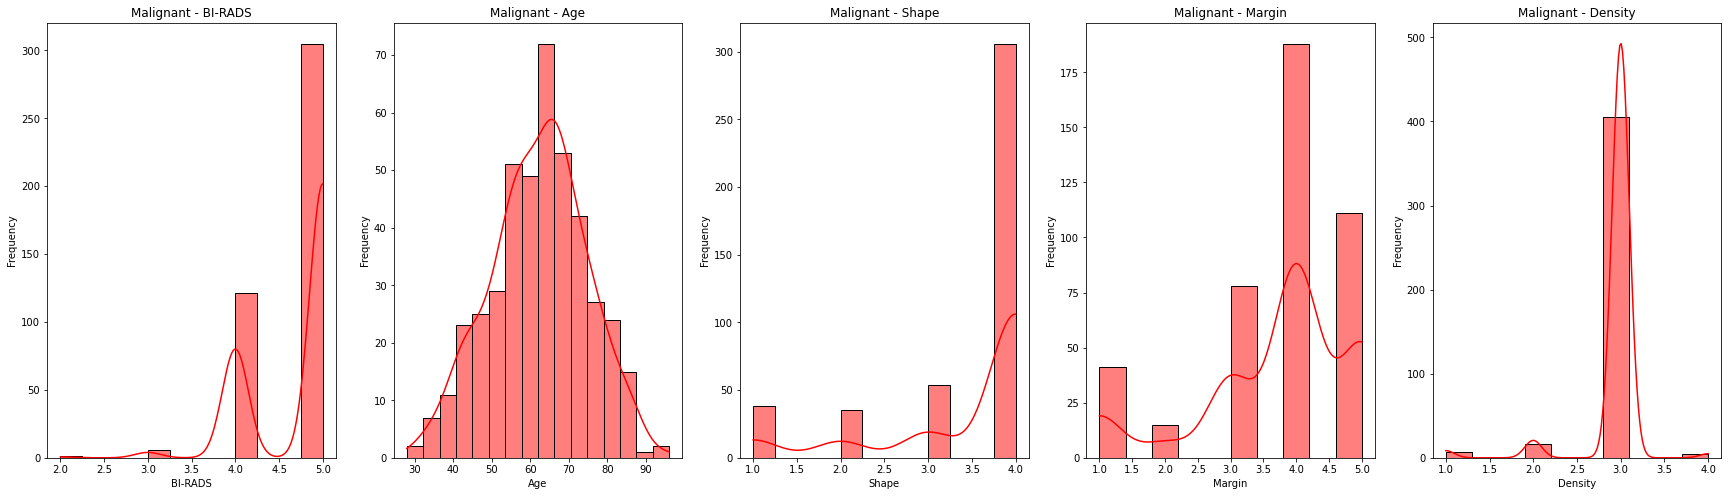

In [96]:
f, axes = plt.subplots(ncols=5, figsize=(30, 8))

for i, col in enumerate(data.columns[0:5]):
    data_malign = data[col][data.Severity == 1].values
    sns.histplot(data_malign, ax=axes[i], kde=True, color='red')
    axes[i].set_title('Malignant - ' + col)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.show()

Correlation Matrices

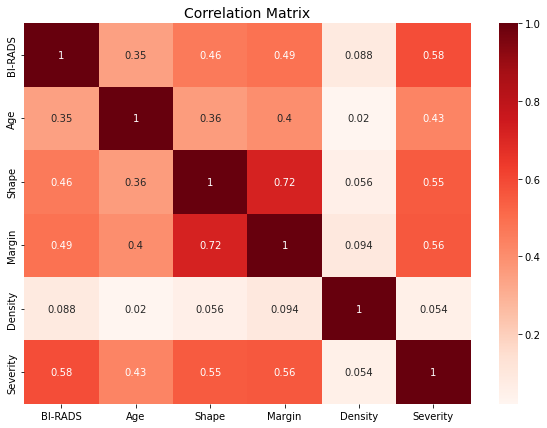

In [97]:
corr = data.corr()

plt.figure(figsize=(10, 7))

sns.heatmap(corr, annot=True, cmap=plt.cm.Reds)
plt.title('Correlation Matrix', fontsize=14)
plt.show()

Box and Whisker Plot

Text(0.5, 1.0, 'Severity - Margin')

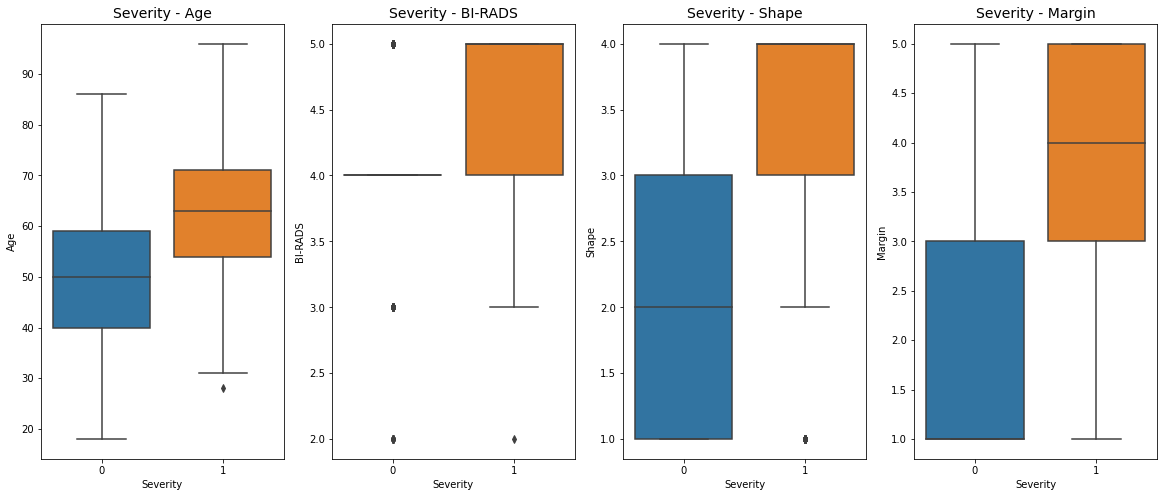

In [98]:
f, axes = plt.subplots(ncols=4, figsize=(20, 8))

sns.boxplot(x='Severity', y='Age', data=data, ax=axes[0])
axes[0].set_title('Severity - Age', fontsize=14) 

sns.boxplot(x='Severity', y='BI-RADS', data=data, ax=axes[1])
axes[1].set_title('Severity - BI-RADS', fontsize=14) 

sns.boxplot(x='Severity', y='Shape', data=data, ax=axes[2])
axes[2].set_title('Severity - Shape', fontsize=14)

sns.boxplot(x='Severity', y='Margin', data=data, ax=axes[3])
axes[3].set_title('Severity - Margin', fontsize=14) 


Standardization, Normalization

In [99]:
features_values = data.values[:, 0:5]
severity_values = data['Severity']

print(severity_values.shape)
print(features_values.shape)

severity_values = severity_values.values.reshape(-1, 1)
print(severity_values.shape)

(944,)
(944, 5)
(944, 1)


In [100]:
scaler  = StandardScaler()
features_values = scaler.fit_transform(features_values)
features_values

array([[ 1.1479474 ,  0.80327507,  0.22915791,  1.44025222,  0.22871089],
       [-0.48653578, -0.8585823 , -1.40348413, -1.17310309,  0.22871089],
       [ 1.1479474 ,  0.18007856,  1.04547894,  1.44025222,  0.22871089],
       ...,
       [-0.48653578,  0.5955429 ,  1.04547894,  1.44025222,  0.22871089],
       [ 1.1479474 ,  0.73403102,  1.04547894,  1.44025222,  0.22871089],
       [-0.48653578,  0.45705479,  0.22915791,  0.13357457,  0.22871089]])

# Model

Model training

In [101]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(features_values, severity_values, test_size=0.2, random_state=0)

Model  training, Model hyper-parameter selection, onfusion Matrix

In [143]:
def train(model, X_train, X_test, y_train, y_test ):
    print("Training Model: ", model.__class__.__name__)
    model.fit(X_train, np.ravel(y_train))
    y_pred = model.predict(X_test)
    test_data_acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print("Accuracy: ", test_data_acc)
    print("F1 Score: ", f1)
    
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix: ")
    print(cm)
        
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()
    
    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    plt.plot(fpr, tpr, color='orange', label='ROC (AUC = %0.2f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    
    print("Classification Report:")
    print(classification_report(y_test, model.predict(X_test)))
    
def hyper_parameter(hypertuned_model, parameters, X_train, y_train):
    print("Hyper Parameter Tuning for :", hypertuned_model.__class__.__name__)
    model = GridSearchCV(hypertuned_model, parameters, scoring="accuracy")
    model.fit(X_train, np.ravel(y_train))
    print(" Best Params: ", model.best_params_)
    return model.best_params_

def k_fold_cross_validation(model, k , X_train, y_train):
    print("K-Fold Cross Validation for :", model.__class__.__name__)
    kfold = KFold(n_splits=k, shuffle=True)
    scores = cross_validate(model, X_train, np.ravel(y_train), scoring="accuracy", cv=k, return_estimator=True)
    return scores["estimator"][np.argmax(scores["test_score"])]

## Logistic Regression

Logistic Regression - Base Model
Training Model:  LogisticRegression
Accuracy:  0.873015873015873
F1 Score:  0.8518518518518519
Confusion Matrix: 
[[96 10]
 [14 69]]


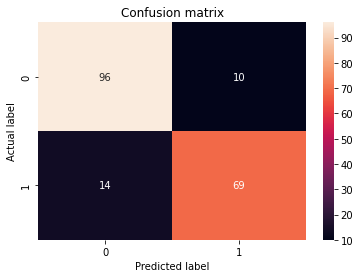

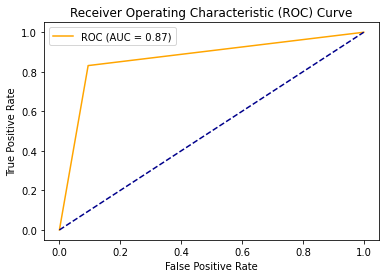

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       106
           1       0.87      0.83      0.85        83

    accuracy                           0.87       189
   macro avg       0.87      0.87      0.87       189
weighted avg       0.87      0.87      0.87       189

#############################

Hyper Parameter Tuning for : LogisticRegression
 Best Params:  {'C': 10, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Training Model:  LogisticRegression
Accuracy:  0.8677248677248677
F1 Score:  0.8466257668711658
Confusion Matrix: 
[[95 11]
 [14 69]]


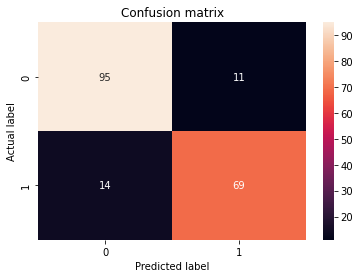

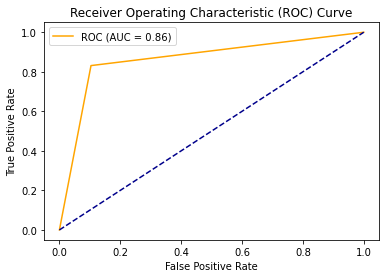

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.90      0.88       106
           1       0.86      0.83      0.85        83

    accuracy                           0.87       189
   macro avg       0.87      0.86      0.87       189
weighted avg       0.87      0.87      0.87       189

#############################

K-Fold Cross Validation for : LogisticRegression
Training Model:  LogisticRegression
Accuracy:  0.8677248677248677
F1 Score:  0.8466257668711658
Confusion Matrix: 
[[95 11]
 [14 69]]


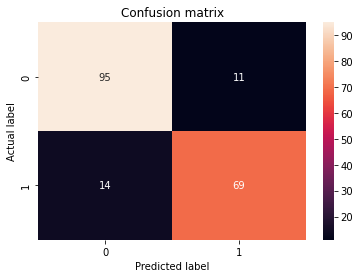

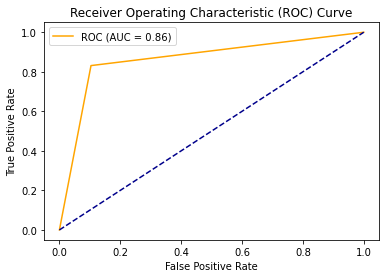

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.90      0.88       106
           1       0.86      0.83      0.85        83

    accuracy                           0.87       189
   macro avg       0.87      0.86      0.87       189
weighted avg       0.87      0.87      0.87       189



In [144]:
logisticRegression = LogisticRegression()

print("Logistic Regression - Base Model")
train(logisticRegression, X_train, X_test, y_train, y_test)

print('#############################\n')

logisticRegressionHyperTuned = LogisticRegression()
parameters = [{'solver': ['liblinear'], 'max_iter': [100, 400, 800], 'C': [0.1, 1, 10, 100, 1000], 'class_weight': ['balanced'], 'penalty': ['l1', 'l2']}]
best_parameters = hyper_parameter(logisticRegressionHyperTuned, parameters, X_train, y_train)

logisticRegressionHyperTuned.set_params(**best_parameters)
train(logisticRegressionHyperTuned, X_train, X_test, y_train, y_test)

print('#############################\n')

logisticRegressionKfmodel = k_fold_cross_validation(logisticRegressionHyperTuned, 5, X_train, y_train)
train(logisticRegressionKfmodel, X_train, X_test, y_train, y_test)



## Neural Network

/home/eva/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of SVM classifier
0.8543046357615894
[[92 14]
 [17 66]]


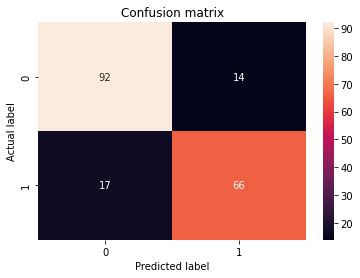

              precision    recall  f1-score   support

           0       0.84      0.87      0.86       106
           1       0.82      0.80      0.81        83

    accuracy                           0.84       189
   macro avg       0.83      0.83      0.83       189
weighted avg       0.84      0.84      0.84       189



In [ ]:
from sklearn.neural_network import MLPClassifier

classifier = MLPClassifier(max_iter=5000)
classifier.fit(X_train, y_train)

print('Accuracy of SVM classifier')
print(classifier.score(X_train,y_train))

y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)

sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

print(classification_report(y_test, y_pred))

## Linearly separable Data (linear SVM)

Accuracy of SVM classifier
0.8172185430463577


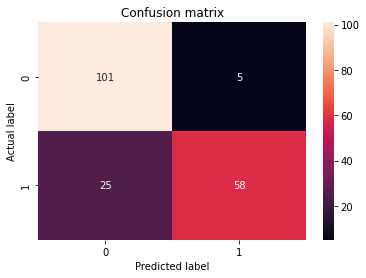

In [ ]:
# C = 1
classifier = SVC(C=1, kernel="linear")
classifier.fit(X_train,np.ravel(y_train))

print('Accuracy of SVM classifier')
print(classifier.score(X_train,y_train))

y_pred = classifier.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

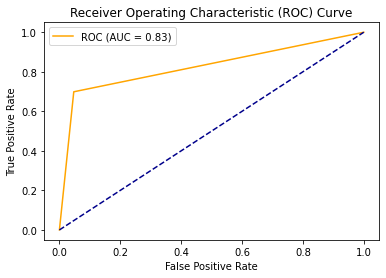

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.plot(fpr, tpr, color='orange', label='ROC (AUC = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.95      0.87       106
           1       0.92      0.70      0.79        83

    accuracy                           0.84       189
   macro avg       0.86      0.83      0.83       189
weighted avg       0.85      0.84      0.84       189



## Nonlinearly separable data  (SVM with Gaussian RBF Kernel)

Accuracy of SVM classifier
0.9112582781456954


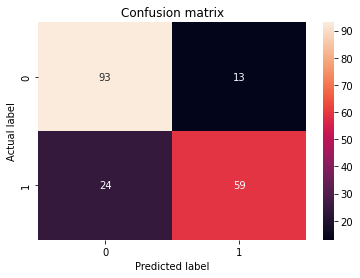

In [ ]:
svc = SVC(kernel='rbf', C=1, gamma=30)
svc = svc.fit(X_train, np.ravel(y_train))

print('Accuracy of SVM classifier')
print(svc.score(X_train, y_train))

y_pred = svc.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

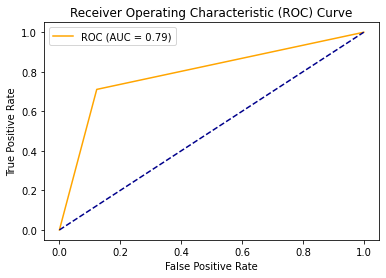

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.plot(fpr, tpr, color='orange', label='ROC (AUC = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.88      0.83       106
           1       0.82      0.71      0.76        83

    accuracy                           0.80       189
   macro avg       0.81      0.79      0.80       189
weighted avg       0.81      0.80      0.80       189



## Nonlinear SVM with Gaussian Kernels, optimization of C and  $\sigma$ (Dataset 3)

In [ ]:
# Hyperparameter tuning
def dataset3Params(X, y,vals):
    """
    dataset3Params returns the optimal C and gamma(1/sigma) based on a cross-validation set.
    """
    acc = 0
    best_C=0
    best_gamma=0
    for i in vals:
        C= i
        for j in vals:
            gamma = 1/j
            classifier = SVC(C=C,gamma=gamma)
            classifier.fit(X,y)
            prediction = classifier.predict(X)
            score = classifier.score(X,y)
            if score>acc:
                acc =score
                best_C =C
                best_gamma=gamma
    return best_C, best_gamma

In [ ]:
vals = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
best_C, best_gamma = dataset3Params(X_train, y_train.ravel(),vals)

#What are the best C and sigma ?
print(best_C)
print(best_gamma)

#Build an SVM classifier with the best C and gamma and get classifier score of about 95% ? (training data accuracy) 
classifier = SVC(C=best_C, gamma=best_gamma, kernel="rbf")
classifier.fit(X_train,np.ravel(y_train))
print('Accuracy of SVM classifier')
print(classifier.score(X_train,y_train))

10
100.0
Accuracy of SVM classifier
0.9364238410596026


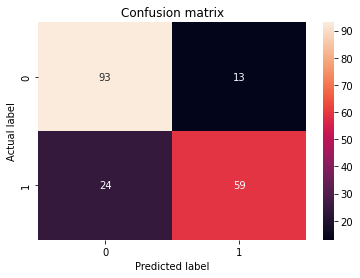

In [ ]:
y_pred = svc.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

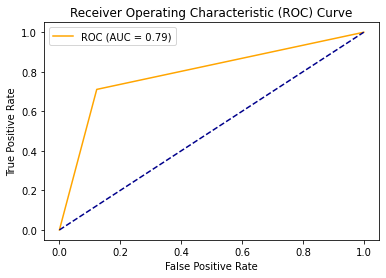

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.plot(fpr, tpr, color='orange', label='ROC (AUC = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.88      0.83       106
           1       0.82      0.71      0.76        83

    accuracy                           0.80       189
   macro avg       0.81      0.79      0.80       189
weighted avg       0.81      0.80      0.80       189



## PCA

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca_features = pca.fit_transform(features_values)
print(features_values.shape)
print(pca_features.shape)

plt.figure(figsize=(10, 7))
plt.bar([1,2,3], pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step([1,2,3], np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.show()